# Climate and Precipitation Analysis

In [1]:
#import dependencies/necessary tools
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#reflect hawaii database
Base = automap_base()
Base.prepare(engine, reflect=True)

#view classes
Base.classes.keys()

['measurement', 'station']

In [4]:
#save reference to measurement class
Measurement = Base.classes.measurement

#save reference to station class
Station = Base.classes.station

In [5]:
#create inspector to view columns in classes
inspector = inspect(engine)

In [6]:
#pull column names from each class
m_columns = inspector.get_columns("Measurement")
s_columns = inspector.get_columns("Station")

In [7]:
#viewing measurement columns
for col in m_columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#viewing station columns
for col in s_columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
#create session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#get most recent date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
#pulling the date one year before the last date
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

#querying the data from the last 12 months
last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).all()

#saving the query to a dataframe with date as the index
last_12_months_prcp_df = pd.DataFrame(last_12_months_prcp)
last_12_months_prcp_df.set_index('date', inplace=True)

#sorting the df by date
last_12_months_prcp_df.sort_values(by='date', inplace=True)

#dropping null values
last_12_months_prcp_df.dropna(inplace=True)

last_12_months_prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


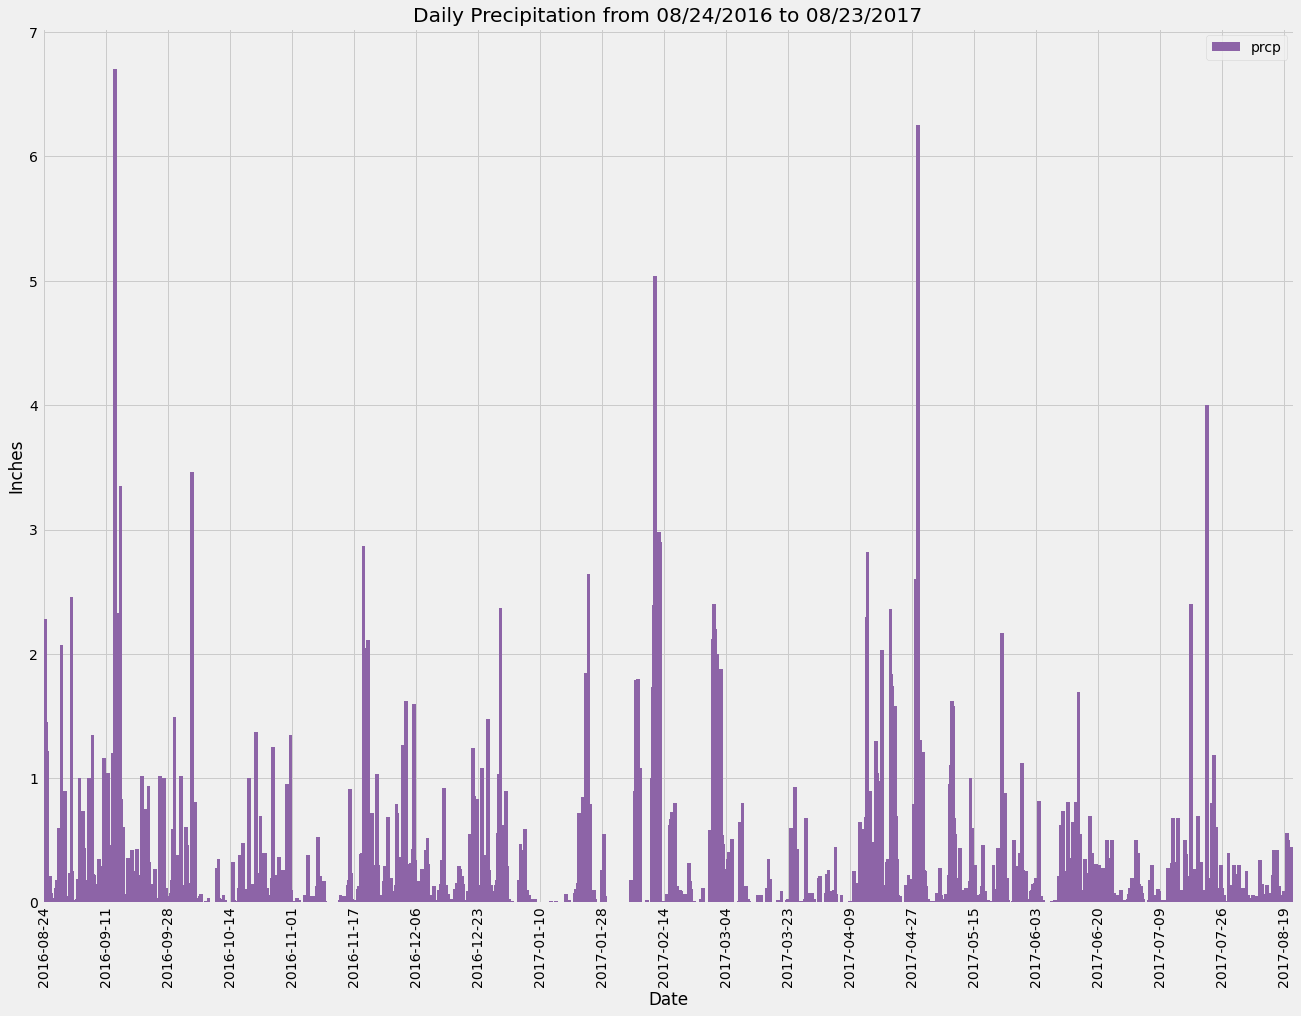

In [12]:
#plotting results with df.plot
last_12_months_prcp_df.plot(kind='bar', figsize=(20, 15), width=6, color='#8D64A7')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Daily Precipitation from 08/24/2016 to 08/23/2017')
plt.xticks(np.arange(0, len(last_12_months_prcp_df)+1, 100))

plt.show()

In [13]:
#print summary statistics
last_12_months_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
#count the number of stations
session.query(func.count(distinct(Station.name))).all()

[(9)]

In [15]:
#find the most active station by listing all the stations and observation counts in descending order
#(https://docs.sqlalchemy.org/en/14/core/metadata.html?highlight=join#sqlalchemy.schema.Table.join)
session.query(Station.id, func.count(Measurement.station), Station.name).\
    select_from(Measurement).\
    join(Station, Measurement.station == Station.station).\
    group_by(Station.name).\
    order_by(func.count(Measurement.station).desc()).all()

[(7, 2772, 'WAIHEE 837.5, HI US'),
 (1, 2724, 'WAIKIKI 717.2, HI US'),
 (2, 2709, 'KANEOHE 838.1, HI US'),
 (6, 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (9, 2612, 'MANOA LYON ARBO 785.2, HI US'),
 (3, 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (8, 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 (4, 1372, 'PEARL CITY, HI US'),
 (5, 511, 'UPPER WAHIAWA 874.3, HI US')]

The station with id 7 (WAIHEE 837.5, HI US) has the highest observation count (2772) and is therefore the most active station.

In [16]:
#lowest temperature at station 7
low_temp = session.query(func.min(Measurement.tobs)).\
    select_from(Measurement).\
    join(Station, Measurement.station == Station.station).\
    filter(Station.id == 7).all()

#highest temperature at station 7
high_temp = session.query(func.max(Measurement.tobs)).\
    select_from(Measurement).\
    join(Station, Measurement.station == Station.station).\
    filter(Station.id == 7).all()

#average temperature at station 7
avg_temp = session.query(func.avg(Measurement.tobs)).\
    select_from(Measurement).\
    join(Station, Measurement.station == Station.station).\
    filter(Station.id == 7).all()

print(f'Lowest Temp: {low_temp}, Highest Temp: {high_temp}, Average Temp: {avg_temp}')

Lowest Temp: [(54.0,)], Highest Temp: [(85.0,)], Average Temp: [(71.66378066378067,)]


In [17]:
#get last 12 months of TOBS data for all stations
last_12_months_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > one_year_ago).all()

In [18]:
#get last 12 months of TOBS data, filtered by most active station
last_12_months_tobs_st7 = session.query(Measurement.date, Measurement.tobs).\
    select_from(Measurement).\
    join(Station, Measurement.station == Station.station).\
    filter(Measurement.date > one_year_ago).\
    filter(Station.id == 7).all()

#saving the query to a dataframe with date as the index
last_12_months_tobs_st7_df = pd.DataFrame(last_12_months_tobs_st7)
last_12_months_tobs_st7_df.set_index('date', inplace=True)

#sorting the df by date
last_12_months_tobs_st7_df.sort_values(by='date', inplace=True)

#dropping null values
last_12_months_tobs_st7_df.dropna(inplace=True)

last_12_months_tobs_st7_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


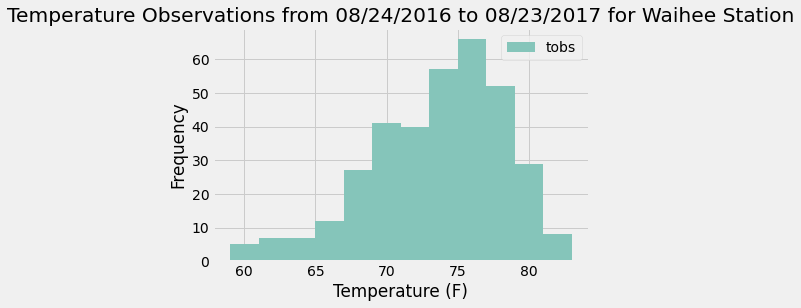

In [19]:
#plot histogram for station 7
last_12_months_tobs_st7_df.plot(kind='hist', bins=12, color='#85C5BA')
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
plt.title('Temperature Observations from 08/24/2016 to 08/23/2017 for Waihee Station')

plt.show()

# Close Session

In [20]:
# Close Session
session.close()